<a href="https://colab.research.google.com/github/aissak21/aissak21.github.io/blob/master/COVID_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load Packages**

In [35]:
import torch #Pytorch = DL library

import os #Operating system = interact with os

import numpy as np #Numpy = array-processing package.

import pandas as pd # Pandas = data manipulation tool

from tqdm import tqdm #Progress = make your loops show a progress meter

import seaborn as sns #Seaborn =  library for making statistical graphics in Python

from pylab import rcParams #Pylab = bulk import (matplotlib, numpy...)

import matplotlib.pyplot as plt #Pyplot = a collection of functions that make matplotlib work like MATLAB.

from matplotlib import rc #Matplotlib = visualization in Python

from sklearn.preprocessing import MinMaxScaler #Sklearn = ML in python: classification, regression, clustering...

from pandas.plotting import register_matplotlib_converters

from torch import nn, optim #From module, import a specific aspect

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE","#FFDD00","#FF7D00","#FF006D","#93D30C","#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14,10

register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Import Data as Pandas DF

In [36]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df.head() #See the column headers

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,37054,37054,37162,37269,37345,37424,37431,37551,37596,37599,37599,37599,37856,37894,37953,37999,38054,38070,38113,38129,38140,38143,38162,38165,38196,38243,38288,38304,38324,38398,38494,38520,38544,38572,38606,38641,38716,38772,38815,38855
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6275,6411,6536,6676,6817,6971,7117,7260,7380,7499,7654,7812,7967,8119,8275,8427,8605,8759,8927,9083,9195,9279,9380,9513,9606,9728,9844,9967,10102,10255,10406,10553,10704,10860,11021,11185,11353,11520,11672,11816
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,34693,35160,35712,36204,36699,37187,37664,38133,38583,39025,39444,39847,40258,40667,41068,41460,41858,42228,42619,43016,43403,43781,44146,44494,44833,45158,45469,45773,46071,46364,46653,46938,47216,47488,47752,48007,48254,48496,48734,48966
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,955,955,963,963,977,981,989,989,989,1005,1005,1024,1024,1045,1045,1045,1060,1060,1098,1098,1124,1124,1124,1176,1184,1199,1199,1215,1215,1215,1261,1261,1301,1301,1344,1344,1344,1438,1438,1483
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1572,1672,1679,1735,1762,1815,1852,1879,1906,1935,1966,2015,2044,2068,2134,2171,2222,2283,2332,2415,2471,2551,2624,2654,2729,2777,2805,2876,2935,2965,2981,3033,3092,3217,3279,3335,3388,3439,3569,3675


#Data Exploration

In [37]:
df.head() #See the column headers
df = df.iloc[:,4:] #Drop first 4 columns
df.head() #New df with no qualitative data
df.isnull().sum() #Check for missing values

1/22/20    0
1/23/20    0
1/24/20    0
1/25/20    0
1/26/20    0
          ..
9/12/20    0
9/13/20    0
9/14/20    0
9/15/20    0
9/16/20    0
Length: 239, dtype: int64

In [38]:
daily_cases = df.sum(axis=0) #each column in the represents a daily case, sum the rows for all cases in a day
daily_cases.head()

1/22/20     555
1/23/20     654
1/24/20     941
1/25/20    1434
1/26/20    2118
dtype: int64

In [39]:
daily_cases.index = pd.to_datetime(daily_cases.index) #Change date time formatting
daily_cases.head()

2020-01-22     555
2020-01-23     654
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

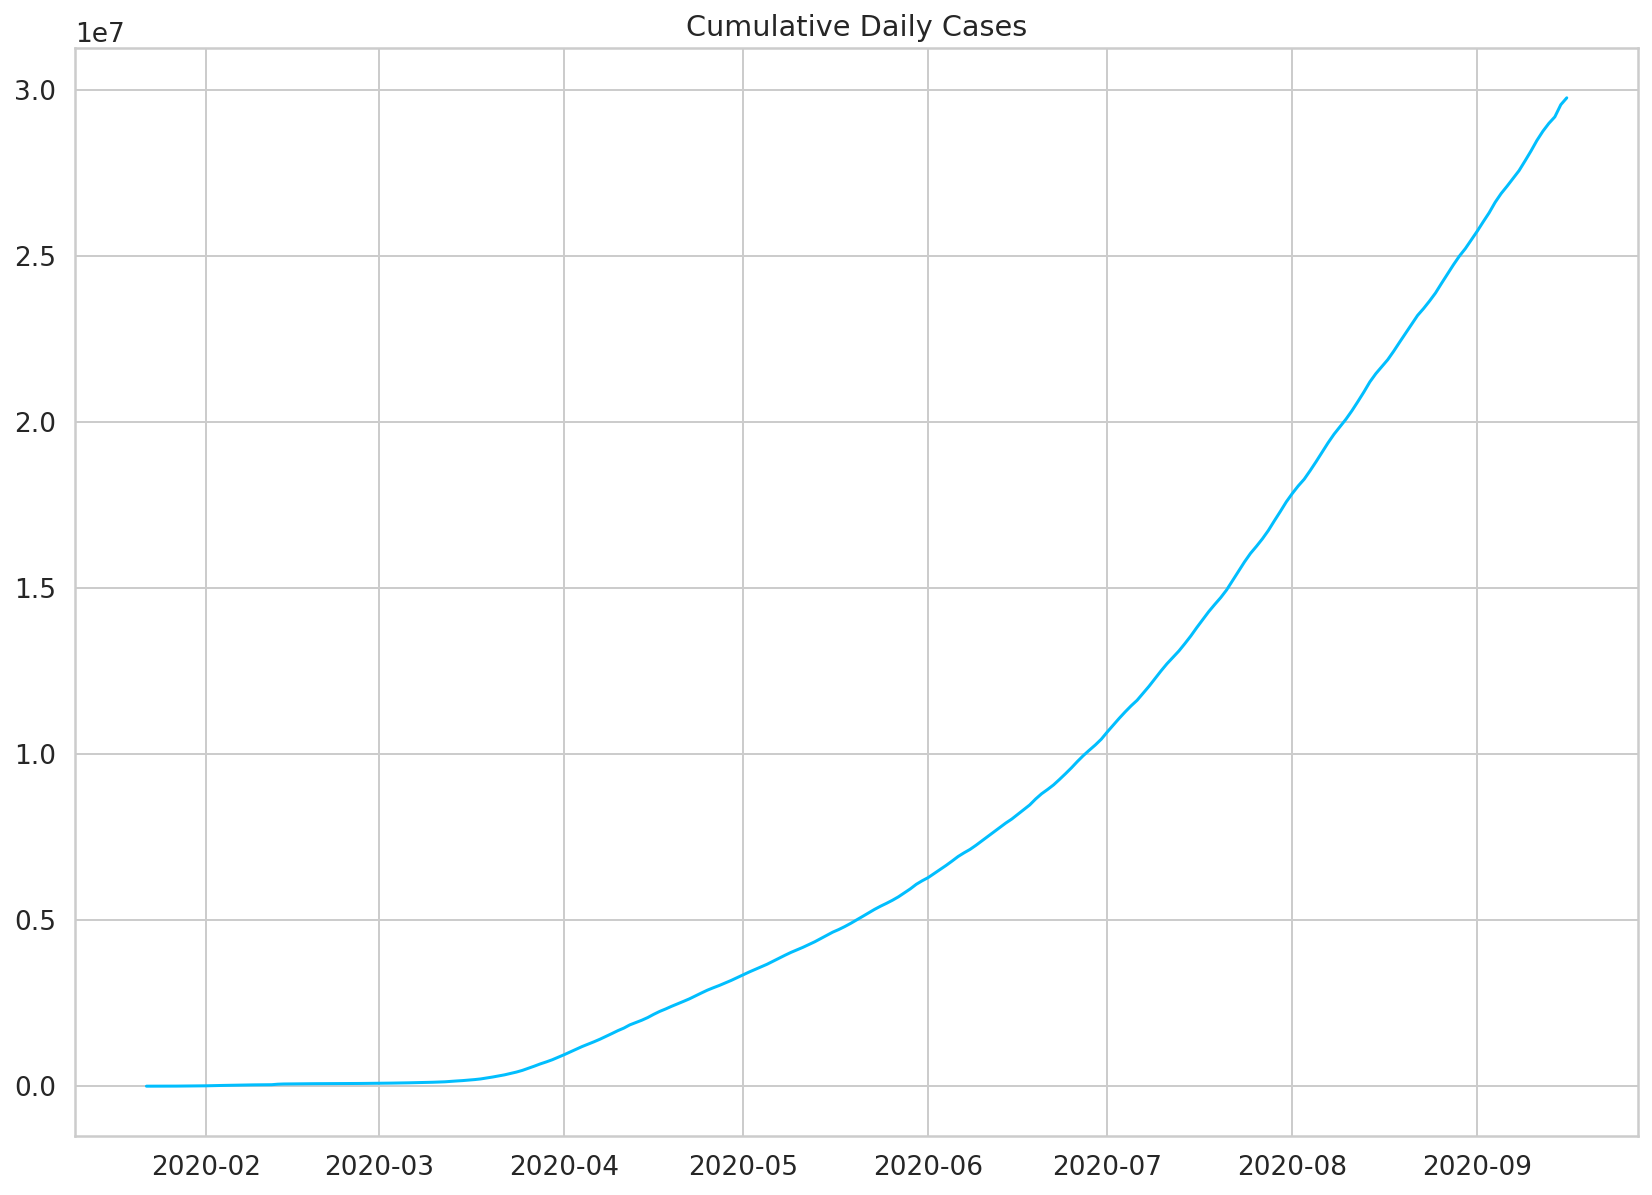

In [40]:
plt.plot(daily_cases)
plt.title('Cumulative Daily Cases');

Taking the difference to see how many cases are found per day

In [41]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     99
2020-01-24    287
2020-01-25    493
2020-01-26    684
dtype: int64

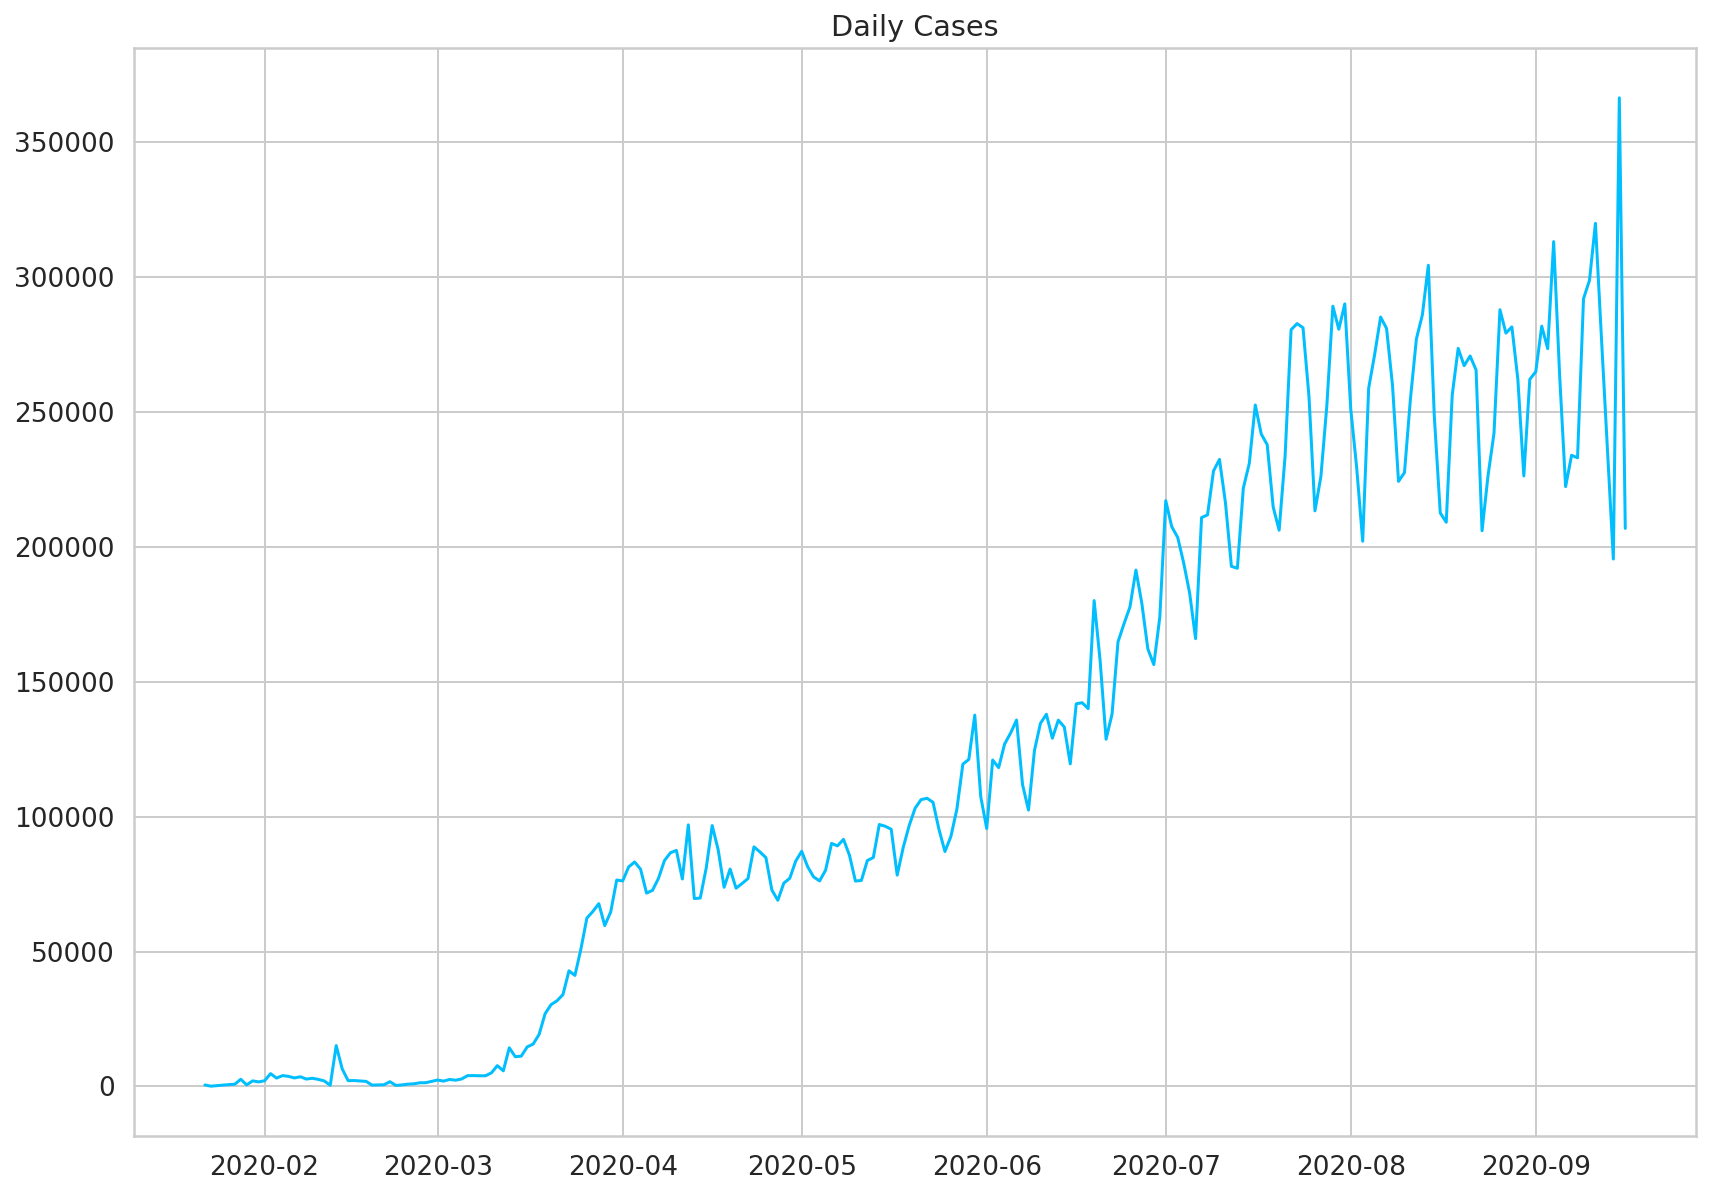

In [42]:
plt.plot(daily_cases)
plt.title('Daily Cases');

In [43]:
daily_cases.shape #239 days worth of data

(239,)

# Preprocessing

In [44]:
test_data_size = 48
train_data = daily_cases[:-test_data_size] #80% training
test_data = daily_cases.iloc[-test_data_size:] #20% testing

In [45]:
train_data.shape

(191,)

In [46]:
test_data.shape

(48,)

In [47]:
scaler = MinMaxScaler() #Default scale from 0 - 1
scaler = scaler.fit(np.expand_dims(train_data, axis=1)) #Create a scale, based on train data

train_data = scaler.transform(np.expand_dims(train_data, axis=1)) #Apply to train date
test_data = scaler.transform(np.expand_dims(test_data, axis=1)) #Apply to test date

In [50]:
# Create sequences. 
#LSTM = sequence based models 

def sliding_windows(data, seq_length):
  xs = []
  ys = []

  for i in range(len(data) - seq_length -1 ):
    
    # Next element in the data. Prediction
    x = data[i:(i+seq_length)]
    y = data[i+seq_length] 

    # Add to our array. Addition
    xs.append(x)
    ys.append(y)

  return np.array(xs), np.array(ys)

In [51]:
seq_length = 5 #Sequence of 5 days to create prediction

x_train, y_train = sliding_windows(train_data, seq_length)
x_test, y_test = sliding_windows(test_data, seq_length)

In [62]:
x_train.shape #Number of sequences, sequnce length, feature
train_data[:15]

array([[0.00157751],
       [0.        ],
       [0.00065038],
       [0.00136302],
       [0.00202378],
       [0.00245621],
       [0.00882853],
       [0.00169167],
       [0.00681166],
       [0.00551091],
       [0.00696388],
       [0.01608646],
       [0.01038182],
       [0.01353338],
       [0.01261317]])

In [59]:
x_train[:3] 
#Last entry in 2nd sequence (x_train) = 1st entry in y_train
#Last entry in 3rd sequence (x_train) = 2nd entry in y_train ...

array([[[0.00157751],
        [0.        ],
        [0.00065038],
        [0.00136302],
        [0.00202378]],

       [[0.        ],
        [0.00065038],
        [0.00136302],
        [0.00202378],
        [0.00245621]],

       [[0.00065038],
        [0.00136302],
        [0.00202378],
        [0.00245621],
        [0.00882853]]])

In [53]:
y_train.shape

(185, 1)

In [60]:
y_train[:3]

array([[0.00245621],
       [0.00882853],
       [0.00169167]])

In [54]:
x_test.shape

(42, 5, 1)

In [55]:
y_test.shape

(42, 1)

In [ ]:
#Create Prediction. LSTM Model
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()


x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

## Building a Model

In [69]:
class CoronaVirusPredictor(nn.Module):

  #Constructor
  def __init__(self, input_dim, hidden_dim, seq_length, num_layers=2): #2 layers: 1. LSTM, 2.Linear
    super(CoronaVirusPredictor, self).__init__()

    #Get variables into properties
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.seq_length = seq_length
    self.num_layers = num_layers

    # 1st layer = LSTM
    self.lstm = nn.LSTM(
      input_size = input_dim, 
      hidden_size = hidden_dim, #no of neurons
      num_layers = num_layers, 
      dropout = 0.5 #eliminates post-processing
    )

    # 2nd layer = Linear
    self.linear = nn.Linear(
      in_features = hidden_dim, 
      out_features = 1
    )

  def reset_hidden_state(self): #define a method
    self.hidden = (
        torch.zeros(self.num_layers, self.seq_length, self.hidden_dim),
        torch.zeros(self.num_layers, self.seq_length, self.hidden_dim)
    )

  def forward(self, input):
    lstm_out, = self.lstm(input.view(len(input), self.seq_length, -1), self.hidden)
    y_pred = self.linear(lstm_out.view(self.seq_len, len(input), self.hidden_dim)[-1]) 

    return y_pred

In [70]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None): #=None implies optional parameter
  loss_fn = nn.MSELoss(reduction = 'sum') #loss is by MSE sum

  optimiser = optim.Adam(model.parameters(),lr = 1e-3) #lr = learning rate, 1e-3 = 0.001

  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()
    y_pred = model(x_train)
    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None: #If we have test data
      with torch.no_grad(): #No gradient calculations
        y_test_pred = model(x_test) #calling model
        test_loss = loss_fn(y_test_pred.float(), y_test) #calculating the loss
      test_hist[t] = test_loss.item() #appending to history

      #Respition t % 10 == 0 means every 10 epochs
      if t % 10 == 0: #print train and test loss
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0: #otherwise just train loss
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item() #Add true loss history

    optimiser.zero_grad() #optimisers gradient

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

Create instance of model

In [71]:
model = CoronaVirusPredictor(1, 512, seq_length = seq_length, num_layers = 2)
model, train_hist, test_hist = train_model(model, x_train, y_train, x_test, y_test)

TypeError: ignored